# Monte Carlo Integration
## Packages and Config

In [1]:
include("MonteCarlo.jl")
using Plots, LaTeXStrings, DataFrames, CSV, BenchmarkTools, SpecialFunctions
figpath = "../fig/"
Plots.default(lw=3, ms=5, marker=:circle, fontfamily="Computer Modern",
    titlefontsize=18, tickfontsize=10, labelfontsize=14, legendfontsize=10)

## $\int_0^2 e^{-x^2} \mathop{dx}$; Uniform Sampling vs. Importance Sampling
This is equal to $\frac{\sqrt{\pi}}{2}\mathrm{erf}(2)$, so it is easy to check the accuracy of the results with julia's built-in error function `erf()`

In [2]:
samples = Integer.([10^n for n in 1:8])
exactintegral = √π/2 * erf(2)

0.8820813907624215

### Uniform Sampling

In [9]:
uniform_integrals = Vector{Float64}(undef, length(samples))
uniform_standard_error = Vector{Float64}(undef, length(samples))
uniform_runtime = Vector{Float64}(undef, length(samples))

for i in 1:length(samples)
    uniform_integrals[i], uniform_standard_error[i] = MonteCarlo.mcintegral(
        x -> ℯ^(-x^2), 0, 2; samples=samples[i])
    bench = @benchmark MonteCarlo.mcintegral(x -> ℯ^(-x^2), 0, 2; samples=$samples[$i])
    uniform_runtime[i] = mean(bench).time * 1e-3
end

uniform_actual_error = abs.(uniform_integrals .- exactintegral)

### Importance Sampling
Here the importance sampling method is used to get more accurate results. The probability density function $e^{-x}$ is the function of choice, which is
$$\frac{e^{-x}}{1-e^{-2}}\ \textrm{in\ the\ range\ $x \in [0, 2]$\ and $0$ elsewhere}$$
when normalized and needs the sampling distribution
$$-\mathrm{ln}\left(1-\left[1-e^{-2}\right]x\right)$$

In [ ]:
importance_integrals = Vector{Float64}(undef, length(samples))
importance_standard_error = Vector{Float64}(undef, length(samples))
importance_runtime = Vector{Float64}(undef, length(samples))
normfactor = 1 - ℯ^(-2)

for i in 1:length(samples)
    importance_integrals[i], importance_standard_error[i] = MonteCarlo.mcintegral(
        x -> ℯ^(-x^2), 0, 2; samples = samples[i], impfunc = x -> ℯ^(-x) / normfactor, impint = 1,
        distribution = x -> -log(1 - normfactor * x))
    bench = @benchmark MonteCarlo.mcintegral(x -> normfactor * ℯ^(-x^2 + x), 0, 2; samples=$samples[$i],
        distribution = x -> -log(1 - normfactor * x))
    importance_runtime[i] = mean(bench).time * 1e-3
end

importance_actual_error = abs.(importance_integrals .- exactintegral)

8-element Vector{Float64}:
 0.05374909865331323
 0.021607991435329543
 0.0007167566468722075
 0.001978765406925098
 0.00048813436356343054
 0.00048019677144184314
 4.187002428834852e-5
 2.303865287212048e-6

### Results

In [ ]:
df = DataFrame("Number of Samples" => samples,
    "Integral Calculated by Uniform Sampling" => uniform_integrals,
    "Integral Calculated by Importance Sampling" => importance_integrals,
    "Uniform Sampling Standard Error" => uniform_standard_error,
    "Importance Sampling Standard Error" => importance_standard_error,
    "Uniform Sampling Actual Error" => uniform_actual_error,
    "Importance Sampling Actual Error" => importance_actual_error,
    "Uniform Sampling Runtime" => uniform_runtime,
    "Importance Sampling Runtime" => importance_runtime)
# save data to file
CSV.write("montecarlo-erf2.csv", df)

"montecarlo-erf2.csv"

In [6]:
# load data from previous runs
df = DataFrame(CSV.File("montecarlo-erf2.csv"))

,Number of Samples,Integral Calculated by Uniform Sampling,Integral Calculated by Importance Sampling
,Int64,Float64,Float64
1,10,0.460596,0.93583
2,100,0.921345,0.903689
3,1000,0.899169,0.882798
4,10000,0.889229,0.880103
5,100000,0.880586,0.881593
6,1000000,0.880835,0.882562
7,10000000,0.882187,0.88204
8,100000000,0.882014,0.882084


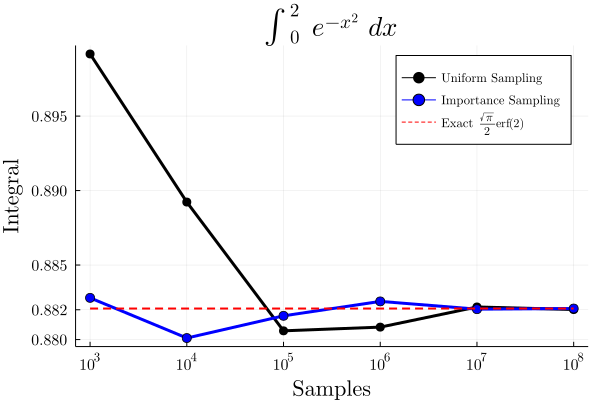

In [7]:
exact = repeat([exactintegral], 8)
uni = df."Integral Calculated by Uniform Sampling"
imp = df."Integral Calculated by Importance Sampling"
yticks = collect(0.88:0.005:0.9)
insert!(yticks, 2, round(exactintegral, digits=3))

p = plot(samples[3:end], [uni[3:end] imp[3:end] exact[3:end]], palette=palette([:black, :blue, :red]),
    markers=[:circle :circle :none], linestyles=[:solid :solid :dash], lw=[3 3 2],
    xlabel="Samples", ylabel="Integral", title=L"\int{}_{0}^{2}\ e^{-x^2}\ dx",
    labels=["Uniform Sampling" "Importance Sampling" "Exact \$\\frac{\\sqrt{\\pi}}{2}\\mathrm{erf}(2)\$"],
    xaxis=:log, xticks=samples[3:end], yticks=yticks)
savefig(p, figpath * "montecarlo-erf2-value.pdf")
display(p)

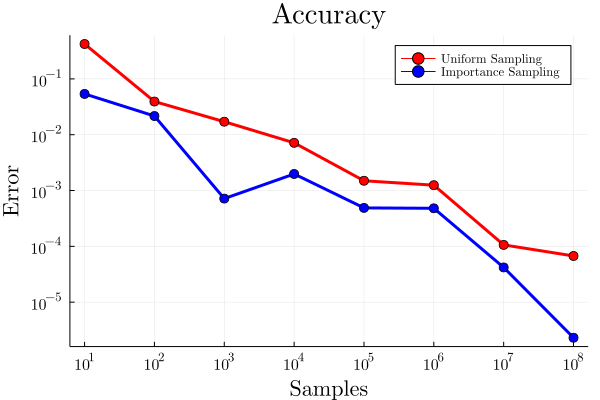

In [8]:
uni = df."Uniform Sampling Actual Error"
imp = df."Importance Sampling Actual Error"

p = plot(samples, [uni imp], xaxis=:log, yaxis=:log, palette=palette([:red, :blue]),
    xlabel="Samples", ylabel="Error", title="Accuracy",
    labels=["Uniform Sampling" "Importance Sampling"],
    xticks=samples, yticks= [10.0^n for n in -6:0])
savefig(p, figpath * "montecarlo-erf2-error.pdf")
display(p)

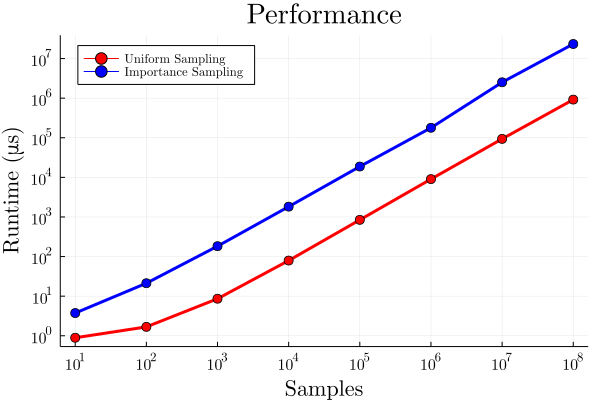

In [9]:
uni = df."Uniform Sampling Runtime"
imp = df."Importance Sampling Runtime"

p = plot(samples, [uni imp], xaxis=:log, yaxis=:log, palette=palette([:red, :blue]),
    xlabel="Samples", ylabel="Runtime (μs)", title="Performance",
    labels=["Uniform Sampling" "Importance Sampling"],
    xticks=samples, yticks=[10.0^n for n in 0:7], legend=:topleft)
savefig(p, figpath * "montecarlo-erf2-time.pdf")
display(p)

## Center of Mass of Sphere with Linearly Increasing Density in One Direction

In [17]:
MonteCarlo.mcintegral(
    (r, θ) -> r^3 * sin(θ) * cos(θ) * (3 + r * cos(θ)),
    [0, 0], [1, π]; samples=40000000)

(0.13333439888468068, 0.0002023288821937912)

In [21]:
MonteCarlo.mcintegral(
    (r, θ) -> r^2 * sin(θ) * (3 + r * cos(θ)),
    [0, 0], [1, π]; samples=40000000)

(2.0002260825411087, 0.0003556876304209698)